# Описание проекта
#### ЗАДАЧА: Необходимо построить модель для определения региона, где добыча нефти принесёт наибольшую прибыль с помощью техники Bootstrap.
#### Условия задачи:
- Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны.
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

#### Шаги для выбора локаций скважен для разработки такие:
1. Делаются пробы и собираются характеристики для скважин в выбранном регионе. Сами названия характеристик нам не ракрываются, это F0, F1 и  F2. Известно, что эти характеристики важны и связаны с объемом запасов в каждой скважине (product). Согласно условиям задачи, выделен бюджет на 500 таких точек.
2. Строится модель для предсказания объёма запасов в данных скважинах.
3. Выбираются скважины, по которым модель дает наибольшее предсказание запасов (200 лучших точек)

#### Pipeline:
1. Разделяем выборки в соотношении train:75% / val:25%
2. Обучаем модель линейной регрессии на данных train (без кросс-валидации, в данной работе это просто этап для техники bootstrap и нам нет необходимости достигать максимальной RMSE)
3. Из выборки 'val' случайным образом выбираем 500 записей - это и будет моделированием деланья проб
4. Получаем предсказания по полученной выборке и из 500 записей выбираем 200 самых лучших
5. Оцениваем прибыль (по фактическим запасам)
6. Повторяем пп. 3-5 1000 раз. Получаем средний показатель прибыли и распределение прибыли
7. Выбираем лучший регион

In [179]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

state = np.random.RandomState(12345)

### Подготовка данных

In [47]:
try:
    geo_data_0 = pd.read_csv('C:/project/project8/geo_data_0.csv')
    geo_data_1 = pd.read_csv('C:/project/project8/geo_data_1.csv')
    geo_data_2 = pd.read_csv('C:/project/project8/geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [48]:
geo_data_0.info()
geo_data_0.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


#### Данные не содержат пропусков, признаки f0-f2 согласно условиям задачи  значимы. Считаю, что никаких дополнительных преобразований датасеты не требуют. Разбиение на features и target проведем в следующем пункте чтобы не разбивать код.

### Обучение и проверка модель для каждого региона:

In [80]:
def reg_evaluation(geo_data): #оценивает по валидационной выборке средний запас предсказанного сырья, 
                              #реальный средний запас, RMSE модели
    features_train, features_val, target_train, target_val = train_test_split(
        geo_data.drop(columns=['id', 'product']), geo_data['product'], test_size=0.25, random_state=12345)
    
    model = LinearRegression() 
    model.fit(features_train, target_train)
    predictions_val = pd.Series(model.predict(features_val))
    print('Средний запас предсказанного сырья', predictions_val.mean())
    print('Реальный запас сырья', target_val.mean())
    print('RMSE модели = ', mean_squared_error(target_val, predictions_val)**(1/2))
    return predictions_val, target_val.reset_index(drop=True)

#### Регион 0

In [89]:
geo_data_0_predictions_valid, geo_data_0_target_valid = reg_evaluation(geo_data_0)

Средний запас предсказанного сырья 92.59256778438005
Реальный запас сырья 92.07859674082941
RMSE модели =  37.5794217150813


#### Регион 1

In [90]:
geo_data_1_predictions_valid, geo_data_1_target_valid = reg_evaluation(geo_data_1)

Средний запас предсказанного сырья 68.72854689544583
Реальный запас сырья 68.72313602437494
RMSE модели =  0.8930992867756178


#### Регион 2

In [91]:
geo_data_2_predictions_valid, geo_data_2_target_valid = reg_evaluation(geo_data_2)

Средний запас предсказанного сырья 94.96504596800506
Реальный запас сырья 94.88423280885489
RMSE модели =  40.02970873393434


#### Модель лучше всего предсказывает значения по региону 1 (RMSE модели практически равен нулю), при этом, средние запасы по данному региону существенно уступают запасам регионов 0 и 2. 

### Расчёт прибыли

####  Функция расчета прибыли по выбранным скважинам и предсказаниям модели:

In [150]:
def profit_counter(predictions, target):
    predictions = predictions.reset_index(drop=True) # после бутстрепа интексы могут дублироваться
    target = target.reset_index(drop=True)
    probs_sorted = predictions.sort_values(ascending=False)[:200] #выбираем 200 скважин с самими большими предсказаниями
    selected = target[probs_sorted.index]    
    profit = selected.sum()*450000 - 10000000000
    return(int(profit))

In [151]:
#регион 0
profit_counter(geo_data_0_predictions_valid, geo_data_0_target_valid)

3320826043

In [152]:
#регион 1
profit_counter(geo_data_1_predictions_valid, geo_data_1_target_valid)

2415086696

In [153]:
#регион 2
profit_counter(geo_data_2_predictions_valid, geo_data_2_target_valid)

2710349963

#### Регион 0 показывает лучшую прогнозируемую прибыль при условии, если бы у нас была возможность провести 25000 проб (размер выборки 'valid')

### Посчитайте риски и прибыль для каждого региона:
#### Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
#### Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [158]:
# При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
# Исходя из этого условия, надо надо создать выборки по 500 точек и посчитать по ним потенциальную прибыль с помощью 
# функции profit_counter
def bootstrap(predictions, target):
    values = []
    for i in range(1000):
        data = pd.DataFrame({'predictions':predictions, 'target':target})
        data_sample = data.sample(n=500, replace=True, random_state=state)
        values.append(profit_counter(data_sample.predictions, data_sample.target))
        val = pd.Series(values)
    print('Cредняя прибыль:', int(val.mean()))
    print('95% доверительный интервал:', int(val.quantile(0.025)),':',int(val.quantile(0.975)))
    print(f'Риск убытков: {(val < 0).mean():.01%}')
    return val

In [165]:
#регион 0
bootstrap0 = bootstrap(geo_data_0_predictions_valid, geo_data_0_target_valid)

Cредняя прибыль: 383228551
95% доверительный интервал: -169850115 : 887963543
Риск убытков: 6.9%


In [166]:
# регион 1
bootstrap1 = bootstrap(geo_data_1_predictions_valid, geo_data_1_target_valid)

Cредняя прибыль: 441058366
95% доверительный интервал: 23103477 : 840267780
Риск убытков: 1.7%


In [167]:
#регион 2
bootstrap2 = bootstrap(geo_data_2_predictions_valid, geo_data_2_target_valid)

Cредняя прибыль: 393279441
95% доверительный интервал: -152926362 : 913588505
Риск убытков: 7.5%


#### Согласно условиям задачи, нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью. Этим критериям соответствует регион № 1.

Построим график распределения прибыли по этому региону:

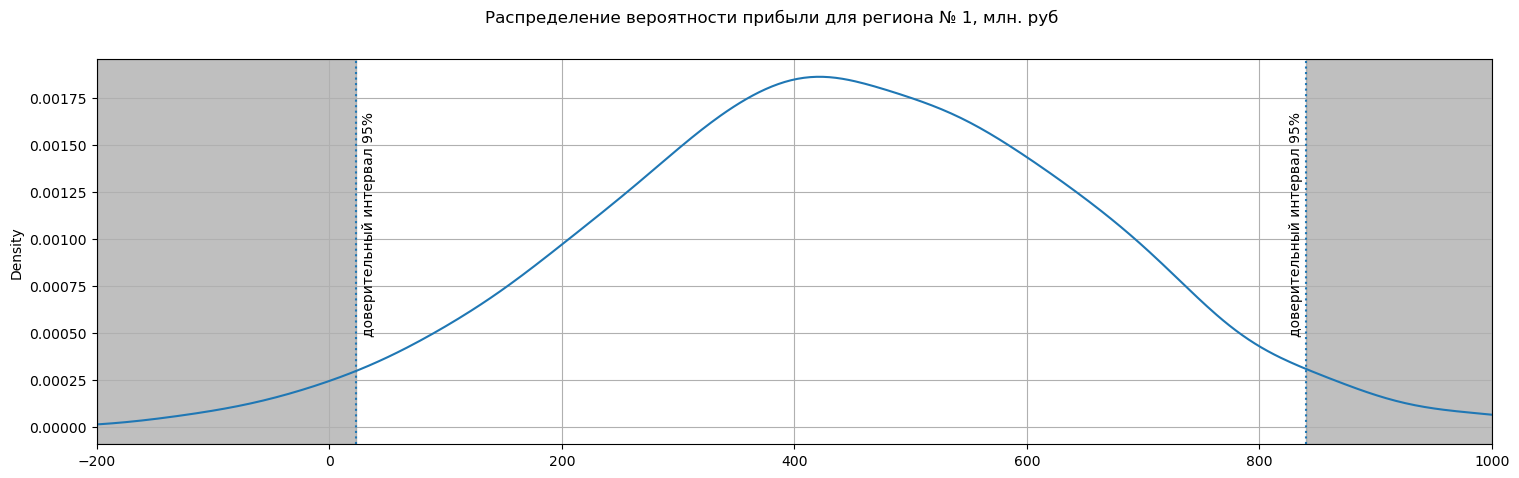

In [234]:
fig, ax = plt.subplots(figsize=(18, 5))
(bootstrap1/1000000).plot(kind='kde', grid=True, ax=ax)
a=plt.axvline((bootstrap1/1000000).quantile(0.025), linestyle='dotted')
plt.text((bootstrap1/1000000).quantile(0.025)+5, 0.0005, 'доверительный интервал 95%', rotation=90)

plt.axvline((bootstrap1/1000000).quantile(0.975), linestyle='dotted')
plt.text((bootstrap1/1000000).quantile(0.975)-15, 0.0005, 'доверительный интервал 95%', rotation=90)
plt.suptitle('Распределение вероятности прибыли для региона № 1, млн. руб')
plt.xlim(-200, 1000)
plt.axvspan(-200, (bootstrap1/1000000).quantile(0.025), color='grey', alpha=0.5)
plt.axvspan((bootstrap1/1000000).quantile(0.975),1000, color='grey', alpha=0.5)
plt.show()

### Выводы

#### Регион № 0 обладает бОльшим количеством высокорентабельных месторождений, поэтому, при выборке 200 лучших точек из 25000, он показывает максимальную прибыльность. 
#### В условиях задачи говорится, что мы не можем оперировать 25000 точками, компания может исследовать в регионе только 500 и из них выбрать 200 лучших согласно модели машинного обучения. Для оценки возможного распределения прибыли, мы 1000 раз формируем выборки по 500 точек из 25000, считаем прибыль для каждой выборки.
#### На основе распределиния прибыли в предыдущем пункте делаем вывод, что единственный регион, который соответствует условию задачи: Регион 1.